This notebook is a proof of concept to test the FaceNet model from https://github.com/nyoki-mtl/keras-facenet on Nividia Jetson TX2. Most of the code was copied from https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

## Load Packages

In [2]:
# import the package needed
import os
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray

import cv2
import tensorflow as tf
import numpy as np
import time


# Not going to use MTCNN for face detection 
# since the dependency issue hasn't been resolved yet.
# from mtcnn.mtcnn import MTCNN

## Detect Faces in Images and Crop

In [3]:
# import tensorflow.contrib.tensorrt as trt
# from tf_trt_models.detection import download_detection_model, build_detection_graph

#load the neural face detector model from hw7 and use it to
# crop faces in the images in our train and dev sets

FROZEN_GRAPH_NAME = 'data/frozen_inference_graph_face.pb'

output_dir=''
frozen_graph = tf.compat.v1.GraphDef()
with open(os.path.join(output_dir, FROZEN_GRAPH_NAME), 'rb') as f:
  frozen_graph.ParseFromString(f.read())

INPUT_NAME='image_tensor'
BOXES_NAME='detection_boxes'
CLASSES_NAME='detection_classes'
SCORES_NAME='detection_scores'
MASKS_NAME='detection_masks'
NUM_DETECTIONS_NAME='num_detections'

input_names = [INPUT_NAME]
output_names = [BOXES_NAME, CLASSES_NAME, SCORES_NAME, NUM_DETECTIONS_NAME]

tf_config = tf.compat.v1.ConfigProto()
tf_config.gpu_options.allow_growth = True
tf_sess = tf.compat.v1.Session(config=tf_config)
tf.import_graph_def(frozen_graph, name='')

tf_input = tf_sess.graph.get_tensor_by_name(input_names[0] + ':0')
tf_scores = tf_sess.graph.get_tensor_by_name('detection_scores:0')
tf_boxes = tf_sess.graph.get_tensor_by_name('detection_boxes:0')
tf_classes = tf_sess.graph.get_tensor_by_name('detection_classes:0')
tf_num_detections = tf_sess.graph.get_tensor_by_name('num_detections:0')

In [4]:
def extract_face(filename, required_size=(160, 160)):
    image = cv2.imread(filename)
    
    if type(image) == type(None):
        return None
    
    if image.shape[2] <= 2:
        return None
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_resized = cv2.resize(image, (300, 300))
    scores, boxes, classes, num_detections = tf_sess.run([tf_scores, tf_boxes, tf_classes, tf_num_detections], feed_dict={
        tf_input: image_resized[None, ...]
    })

    boxes = boxes[0] # in
    scores = scores[0]
    classes = classes[0]
    num_detections = num_detections[0]

    plot_ind = 0
    DETECTION_THRESHOLD = 0.01
    images = []
    for i in range(int(num_detections)):
        if scores[i] < DETECTION_THRESHOLD:
            continue
        # scale box to image coordinates
        box = boxes[i] * np.array([image.shape[0], image.shape[1], image.shape[0], image.shape[1]])
        box = box.astype(int)
        face = image[box[0]:box[2]+1, box[1]:box[3]+1]
        image = Image.fromarray(face)
        image = image.resize(required_size)
        return image
    
# specify folder to plot for testing the function only
# print(os.getcwd())
# folder = 'data/train/elton_john/'
# i = 1
# # enumerate files
# for filename in listdir(folder):
# 	# path
# #     print(filename)
# 	path = folder + filename
# # 	# get face
# 	face = extract_face(path)
# 	print(i, face.shape)
# # 	# plot
# 	pyplot.subplot(2, 7, i)
# 	pyplot.axis('off')
# 	pyplot.imshow(face)
# 	i += 1
# pyplot.show()

In [5]:
def load_faces(directory):
    faces = list()
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        # get face
        face = extract_face(path)
        if not face:
            continue
        # store
        face_array = asarray(face)
        faces.append(face_array)
    return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

# load train dataset
trainX, trainy = load_dataset('data/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('data/val/')
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 14 examples for class: ben_afflek
>loaded 22 examples for class: mindy_kaling
>loaded 19 examples for class: madonna
>loaded 21 examples for class: jerry_seinfeld
>loaded 17 examples for class: elton_john
>loaded 87 examples for class: unknown
(180, 160, 160, 3) (180,)
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: madonna
>loaded 5 examples for class: jerry_seinfeld
>loaded 5 examples for class: elton_john
>loaded 80 examples for class: unknown


In [6]:
tf_sess.close()

## Load Face Images and Generate Embeddings for Training

Load the FaceNet model. Remember to download it from https://drive.google.com/drive/folders/12aMYASGCKvDdkygSv1yQq8ns03AStDO_ and save it into the same directory as this notebook.

In [7]:
# example of loading the keras facenet model
from keras.models import load_model
# load the model
face_net_model = load_model('facenet_keras.h5')
# summarize input and output shape
print(face_net_model.inputs)
print(face_net_model.outputs)

Using TensorFlow backend.


[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/cond/Identity:0' shape=(None, 128) dtype=float32>]


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model

# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

In [9]:
# get embedding for train and test dataset

# load the face dataset
data = load('5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)
# load the facenet model
# model = load_model('facenet_keras.h5')
print('Loaded Model')
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(face_net_model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(face_net_model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
savez_compressed('5-celebrity-faces-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (180, 160, 160, 3) (180,) (105, 160, 160, 3) (105,)
Loaded Model
(180, 128)
(105, 128)


__Unlike the tutorial from which we borrowed the code, we have to use an SVM with a nonlinear kernel (with all the known faces, the decision boundary is very complex) and weight classes inversely by samples in training (the classification is imbalanced. We have more unknown faces in training than known faces).__

In [14]:
# develop a classifier for the 5 Celebrity Faces Dataset
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('5-celebrity-faces-dataset.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('5-celebrity-faces-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
# Notice we are using different hyper params than the original tutorial
classifier = SVC(probability=True, class_weight = "balanced")
classifier.fit(trainX, trainy)




SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Test Model Performance

__We also deviate from the original tutorial a bit here because we would want to generate the embedding for the test examples online in order to see what the resulting image per second we can get.__

In [16]:
# test model on a random example from the test dataset
faces = load('5-celebrity-faces-dataset.npz')
test_faces = faces['arr_2']
testy = data['arr_3']

Predicted: unknown (46.164)
Expected: unknown


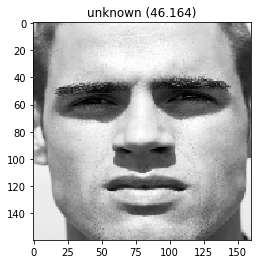

Predicted: unknown (44.114)
Expected: unknown


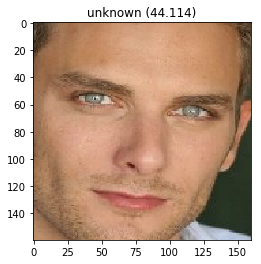

Predicted: unknown (43.885)
Expected: unknown


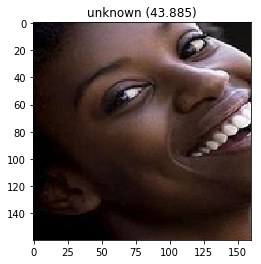

Predicted: unknown (45.984)
Expected: unknown


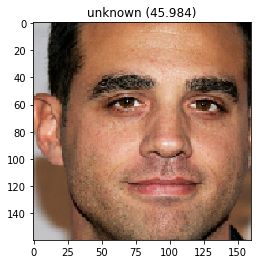

Predicted: mindy_kaling (12.525)
Expected: mindy_kaling


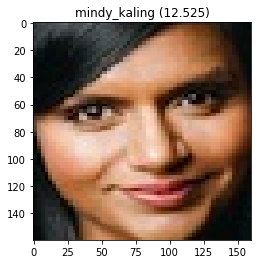

Predicted: unknown (45.284)
Expected: unknown


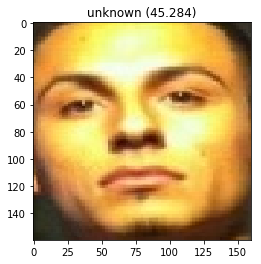

Predicted: unknown (45.545)
Expected: unknown


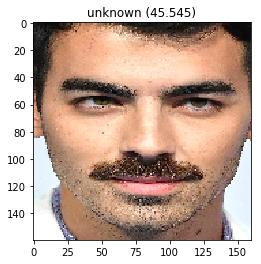

Predicted: madonna (8.303)
Expected: madonna


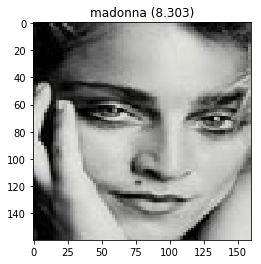

Predicted: unknown (44.287)
Expected: unknown


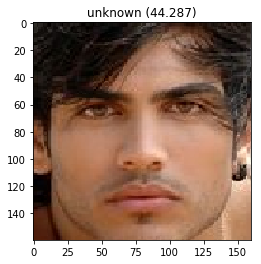

Predicted: unknown (44.141)
Expected: unknown


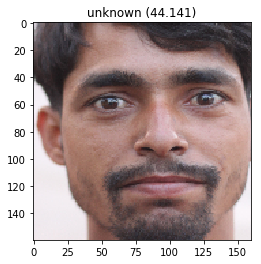

Predicted: unknown (45.579)
Expected: unknown


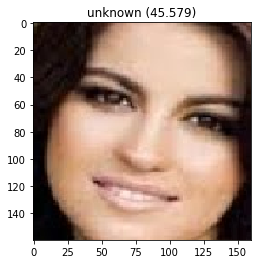

Predicted: unknown (45.426)
Expected: unknown


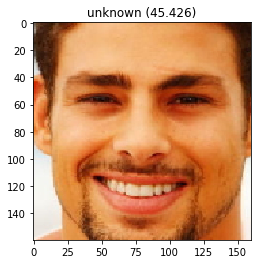

Predicted: unknown (43.981)
Expected: unknown


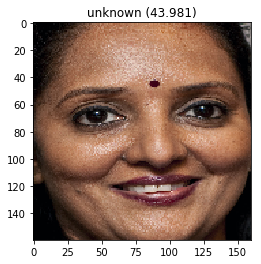

Predicted: unknown (45.314)
Expected: unknown


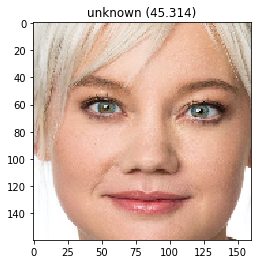

Predicted: unknown (43.819)
Expected: unknown


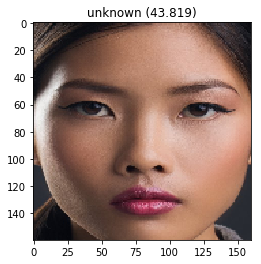

Predicted: unknown (45.364)
Expected: unknown


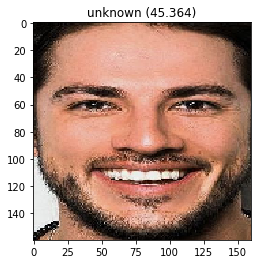

Predicted: unknown (44.403)
Expected: unknown


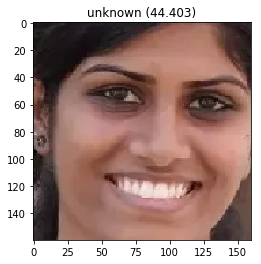

Predicted: unknown (44.434)
Expected: unknown


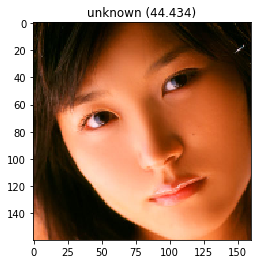

Predicted: unknown (44.114)
Expected: unknown


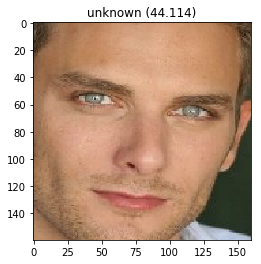

Predicted: madonna (8.303)
Expected: madonna


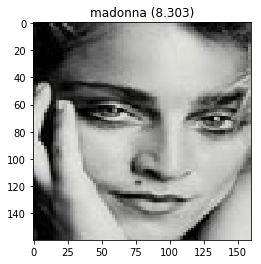

Made 20 inferences
Time taken : 15.978909254074097 seconds
Average 1.251649889362796 images per second
Accuracy = 1.0


In [17]:
import warnings
warnings.filterwarnings('ignore')

def test_model(inference_num, show_each_case=False):
    start = time.time()
    correct = 0
    for i in range(inference_num):
        selection = choice([i for i in range(test_faces.shape[0])])
        random_face_pixels = test_faces[selection]
        # Generate face embeddings using FaceNet online
        random_face_emb = get_embedding(face_net_model, random_face_pixels)
        random_face_class = testy[selection]
        samples = expand_dims(random_face_emb, axis=0)
        yhat_class = classifier.predict(samples)
        yhat_prob = classifier.predict_proba(samples)
        # get name
        class_index = yhat_class[0]
        class_probability = yhat_prob[0,class_index] * 100
        predict_names = out_encoder.inverse_transform(yhat_class)
        
        if show_each_case:
            print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
            print('Expected: %s' % random_face_class)
#             plot for fun
            pyplot.imshow(random_face_pixels)
            title = '%s (%.3f)' % (predict_names[0], class_probability)
            pyplot.title(title)
            pyplot.show()
        if predict_names[0] == random_face_class:
            correct += 1

    end = time.time()
    seconds = end - start

    print(f"Made {inference_num} inferences")
    print("Time taken : {0} seconds".format(seconds))
    print(f"Average {inference_num/seconds} images per second")
    print(f"Accuracy = {correct*1.0/inference_num}")

test_model(20, show_each_case = True)